In [1]:
import torch
import torch.nn as nn
from functools import partial

from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from deit_reg.models_v2 import deit_small_patch16_LS as deit_regs
from deit_source.models_v2 import deit_small_patch16_LS as deit_source
import deit_reg
import deit_source
from deit_reg import models_v2 as models_v2_regs
from deit_source import models_v2 as models_v2_source

from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import math
import random

import os


/home/renan/miniconda3/envs/.deit_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/renan/miniconda3/envs/.deit_env/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/renan/documents/Uni/FACT AI/jip/deit_source/models_v2.py:271: UserWarning: Overwriting deit_tiny_patch16_LS in registry with deit_source.models_v2.deit_tiny_patch16_LS. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/renan/documents/Uni/FACT AI/jip/deit_source/models_v2.py:280: UserWarning: Overwriting dei

In [2]:
# @title get image paths
def get_paths_in_subfolders(folder_path: str) -> list[list[str]]:
  """Given a folder path, returns a list of all image paths in the subfolders.

  Args:
    folder_path: The path to the folder.

  Returns:
    A nested list of all image paths in the subfolders.
  """

  files : list[list[str]] = []
  # Iterate through the subfolders in the given folder
  for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    folder : list[str] = []
    if os.path.isdir(subfolder_path):
      for file_ in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, file_)
        folder.append(file_path)

    files.append(folder)

  return files
     

In [3]:
folder_path = '../imagenette/imagenette2/val/'
image_paths = get_paths_in_subfolders(folder_path)
sample_images = [Image.open(path[0]).convert("RGB") for path in image_paths]

In [4]:
all_images = [Image.open(path[x]).convert("RGB") for path in image_paths for x in range(len(path))]

In [5]:
good_paths = []
for file in os.listdir('../imagenette/good_examples/'):
  good_paths.append(['../imagenette/good_examples/' + file])
good = [Image.open(path[0]).convert("RGB") for path in good_paths]

bad_paths = []
for file in os.listdir('../imagenette/bad_examples/'):
  bad_paths.append(['../imagenette/bad_examples/' + file])
bad = [Image.open(path[0]).convert("RGB") for path in bad_paths]

good_and_bad = good + bad

In [6]:
#code from https://github.com/huggingface/pytorch-image-models/discussions/1232+
def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure()
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]
        attn_obj.reg_attn_maps = attn[:, :, 1:5, 1:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

#original version
def show_first_10(model_name, images):
    for img in images[:10]:
        x = to_tensor(img)

        model = create_model(model_name, pretrained=True)
        model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

        y = model(x.unsqueeze(0))
        attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
        cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

        img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        show_img(img)
        show_img(attn_map)
        show_img(cls_weight)
        show_img(img_resized)
        show_img2(img_resized, cls_resized, alpha=0.8)

# CLS per layer

In [ ]:
pths = os.listdir('../reg_checkpoints')
if "log.txt" in pths:
    pths.remove("log.txt")
if "best_checkpoint.pth" in pths:
    pths.remove("best_checkpoint.pth")
if "checkpoint.pth" in pths:
    pths.remove("checkpoint.pth")
if "deit_reg" in pths:
    pths.remove("deit_reg")

pths = sorted(pths, key=lambda x: int(x.split('checkpoint')[-1].split('.pth')[0]))
print(pths)
pths = [pths[-1]]
# n_imgs = 128
# idx = [random.randint(0, len(all_images)-1) for _ in range(n_imgs)]
# imgs = [all_images[id] for id in idx]

n_imgs = 128
idx = [random.randint(0, len(special)-1) for _ in range(n_imgs)]
imgs = [special[id] for id in idx]

for file in pths:
    checkpoint =torch.load(f'../reg_checkpoints/{file}', map_location=torch.device('cpu'))
    print('epoch', checkpoint['epoch'])
    checkpoint_source = torch.load(f'../source_checkpoints/{file}', map_location=torch.device('cpu'))
    
    model_source = models_v2_source.vit_models(
        img_size = 224, patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=models_v2_source.Layer_scale_init_Block)
    model_source.default_cfg = models_v2_source._cfg()

    model_source.load_state_dict(checkpoint_source["model"])

    model = models_v2_regs.vit_models(
        img_size = 224, patch_size=16, num_regs = 4, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=models_v2_regs.Layer_scale_init_Block)
    model.default_cfg = models_v2_regs._cfg()

    print(checkpoint['model'].keys())

    model.load_state_dict(checkpoint["model"])

    # layers_to_visualize = range(model.get_num_layers())
    output_format = ((7)*2, len(imgs)*2)
    fig, ax = plt.subplots(len(imgs), 3 + model.num_regs, figsize=output_format)
    
    for n_image, image in enumerate(imgs):
        # Display the original image
        x = to_tensor(image)
        img_resized = x.permute(1, 2, 0) * 0.5 + 0.5

        ax[n_image, 0].imshow(np.array(img_resized))
        ax[n_image, 0].axis('off')
        ax[n_image, 0].set_title(idx[n_image])

        s_block = model_source.blocks[-1]
        s_block.attn.forward = my_forward_wrapper(s_block.attn)

        sy = model_source(x.unsqueeze(0))
        sattn_map = s_block.attn.attn_map.mean(dim=1).squeeze(0).detach()
        scls_weight =  s_block.attn.cls_attn_map.mean(dim=1).detach().view(14, 14)
        scls_resized = F.interpolate(scls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        ax[n_image, 1].imshow(scls_weight)
        ax[n_image, 1].axis('off')

        # Display the attention maps for each layer
        block = model.blocks[-1]
        block.attn.forward = my_forward_wrapper(block.attn)

        y = model(x.unsqueeze(0))
        attn_map = block.attn.attn_map.mean(dim=1).squeeze(0).detach()
        cls_weight =  block.attn.cls_attn_map.mean(dim=1)[:, 4:].detach().view(14, 14)
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        ax[n_image, 2].imshow(cls_weight)
        ax[n_image, 2].axis('off')

        reg_weights = block.attn.reg_attn_maps[0].mean(dim=0)

        for n, reg_token in enumerate(reg_weights):
            reg_weight = reg_weights[n, 4:].detach().view(14, 14)
            ax[n_image, n+3].imshow(reg_weight)
            ax[n_image, n+3].axis('off')



    # Set titles only to first row
    ax[0, 0].set_title('Input Image')
    ax[0, 1].set_title('CLS')
    ax[0, 2].set_title('CLS+reg')
    for i in range(model.num_regs):
        ax[0, i+3].set_title(f'reg {i}')

    # plt.xticks(list(layers_to_visualize))
    plt.tight_layout()
    plt.show()

# CLS and REG tokens over epochs

0


/tmp/ipykernel_2058/2693479949.py:34: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.0, hspace=0.0)
/tmp/ipykernel_2058/2693479949.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wh

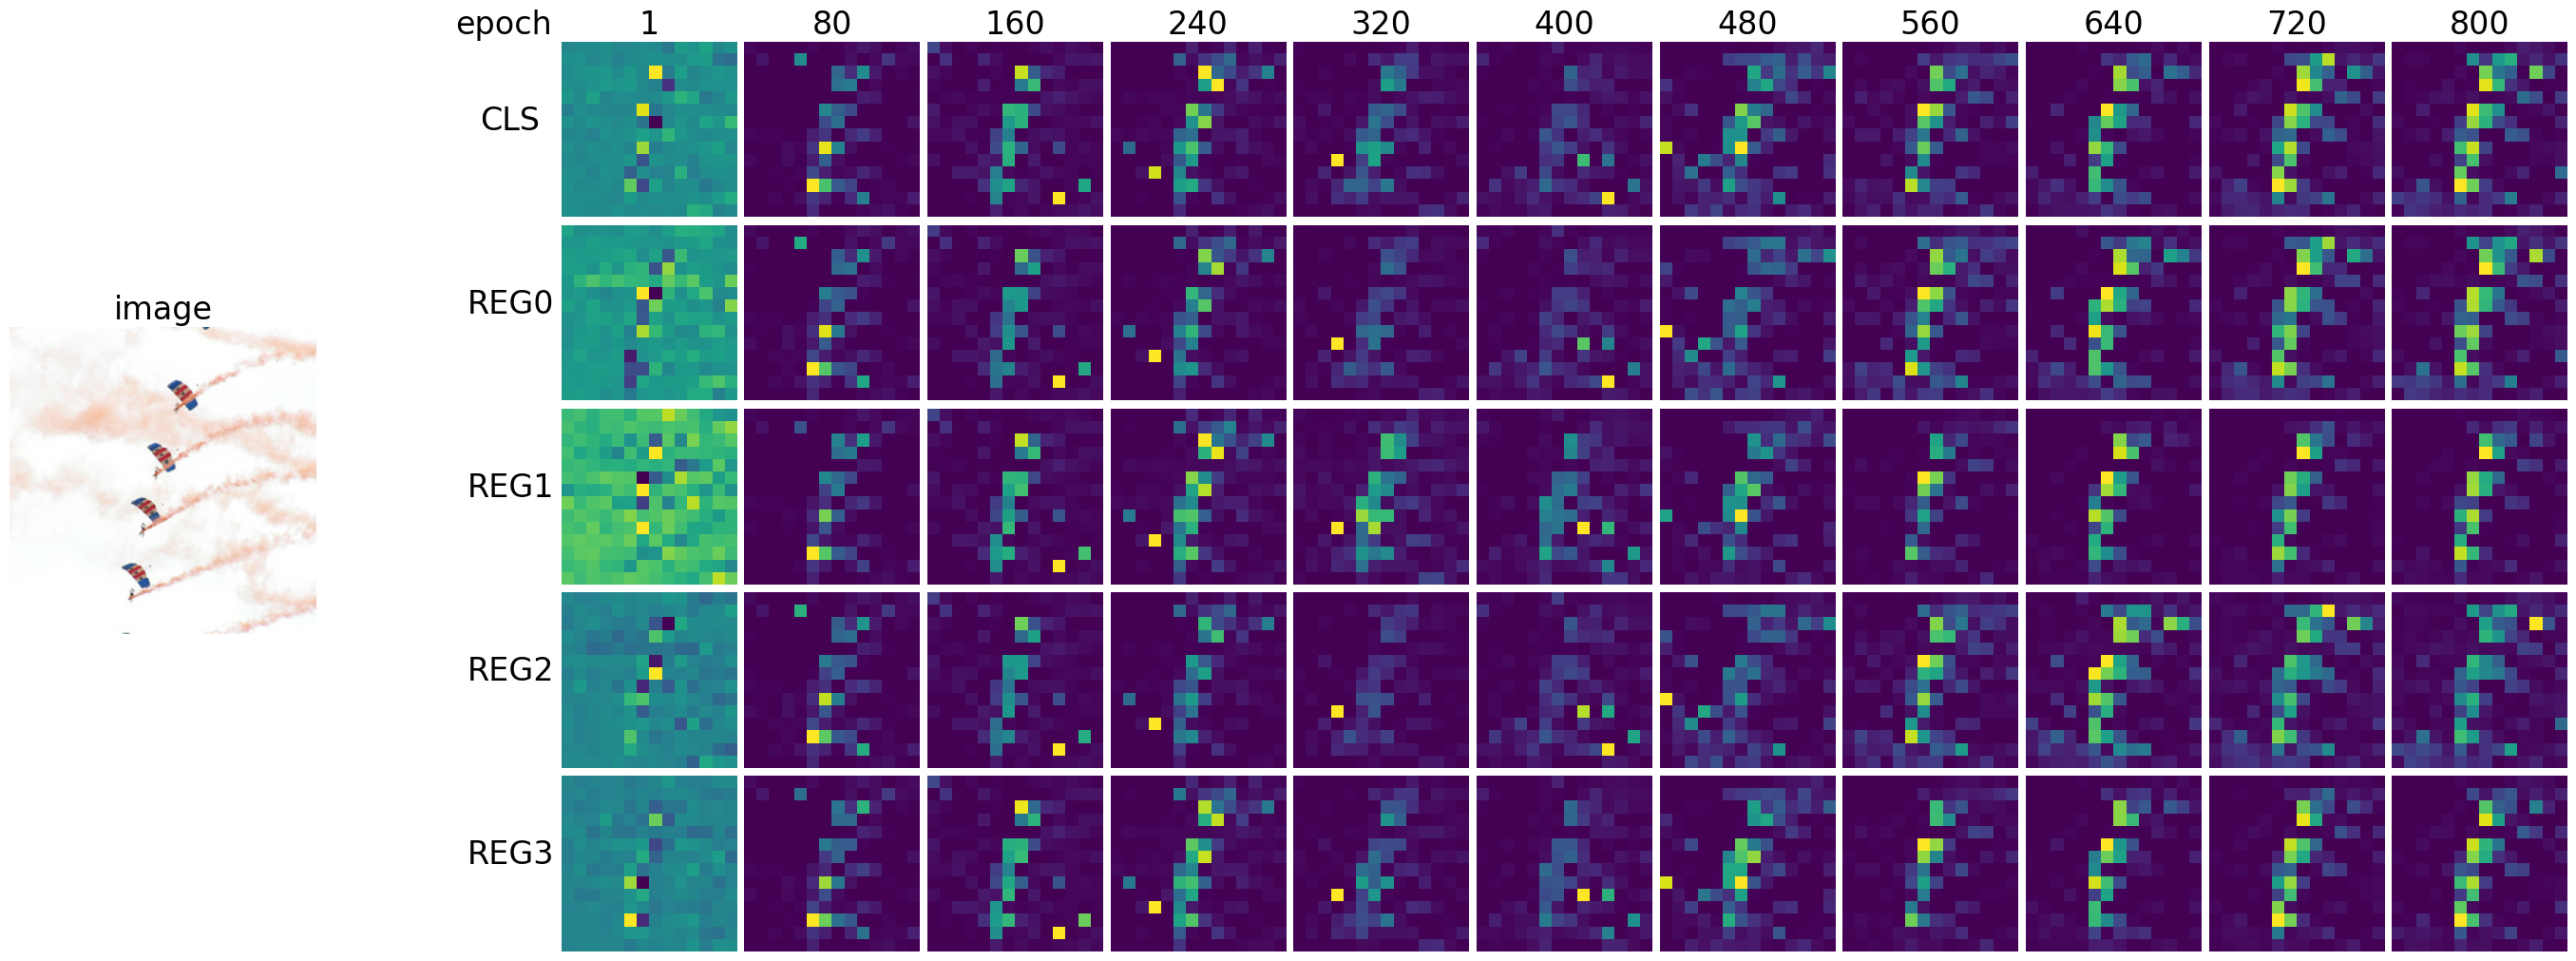

1


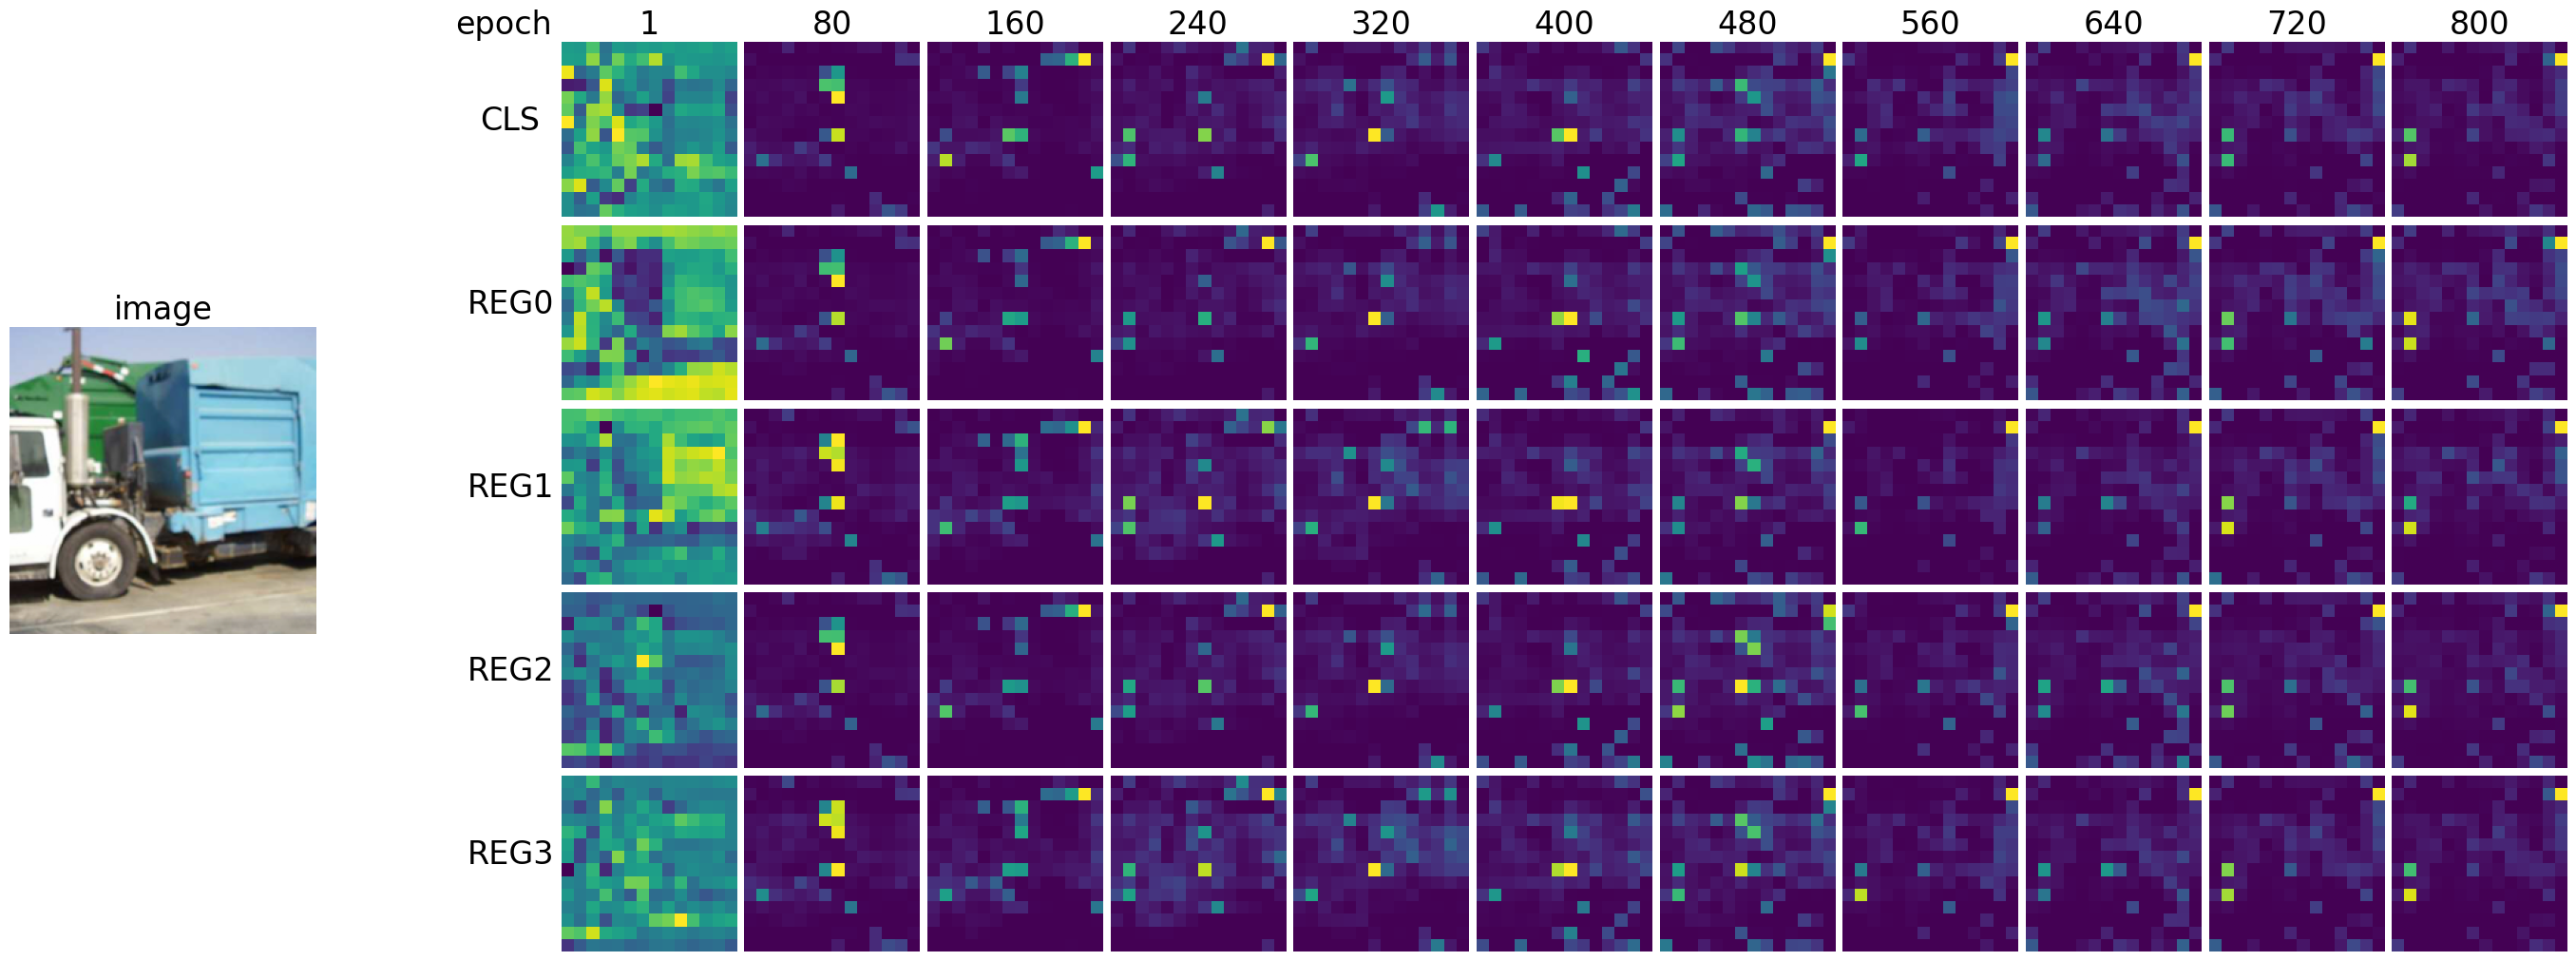

In [53]:
pths = os.listdir('../reg_checkpoints')
if "log.txt" in pths:
    pths.remove("log.txt")
if "best_checkpoint.pth" in pths:
    pths.remove("best_checkpoint.pth")
if "checkpoint.pth" in pths:
    pths.remove("checkpoint.pth")
if "deit_reg" in pths:
    pths.remove("deit_reg")

pths = sorted(pths, key=lambda x: int(x.split('checkpoint')[-1].split('.pth')[0]))
pths = [pths[i] for i in range(0, len(pths), 4)]#[::-1]
# n_imgs = 32
# idx = [random.randint(0, len(all_images)-1) for _ in range(n_imgs)]
# imgs = [all_images[id] for id in idx]
# print(idx)
imgs = good_and_bad
imgs = [imgs[0]] + [imgs[-3]]
idx = range(len(imgs))

gt_paths = pths.copy()

font_sz = 24

for j, img in enumerate(imgs):
    print(idx[j])

    # output_format = ((2+4)*2, len(pths)*2)
    # fig, ax = plt.subplots(len(pths), 2+4, figsize=output_format)
    output_format = ((len(pths)+2.5)*2, (1+4)*2)
    # use gridspec_kw to make the first row have 0 height
    fig, ax = plt.subplots(1+4, len(pths)+1, figsize=output_format, constrained_layout=True, gridspec_kw={'width_ratios': [2.5] + (len(pths)) * [1]})
    # , gridspec_kw={'width_ratios': [1] + (len(include)) * [1]}
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    num_regs = 4
    model = models_v2_regs.vit_models(
        img_size = 224, patch_size=16, num_regs = 4, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=models_v2_regs.Layer_scale_init_Block)
    model.default_cfg = models_v2_regs._cfg()

    x = to_tensor(img)
    img_resized = x.permute(1, 2, 0) * 0.5 + 0.5

    # ax[0, int(len(pths)/2)].imshow(np.array(img_resized))
    # ax[0, int(len(pths)/2)].axis('off')
    # ax[0, int(len(pths)/2)].set_title(f'image')

    gs = plt.GridSpec(5, len(pths)+1, width_ratios=[1.5] + [1] * len(pths), figure=fig)

    ax_img = fig.add_subplot(gs[:, 0])
    ax_img.imshow(np.array(img_resized))
    ax_img.axis('off')
    ax_img.set_title('image', fontsize=font_sz)

    # turn axis off for all subplots on the first column
    for row in range(5):
        ax[row, 0].axis('off')

    for i, file in enumerate(pths):
        i+=1
        checkpoint =torch.load(f'../reg_checkpoints/{file}', map_location=torch.device('cpu'))

        model.load_state_dict(checkpoint["model"])

        x = to_tensor(img)
        img_resized = x.permute(1, 2, 0) * 0.5 + 0.5

        # ax[i, 0].imshow(np.array(img_resized))
        # ax[i, 0].axis('off')
        # ax[i, 0].set_title(f'epoch {checkpoint["epoch"]}')
        # ax[0, i].imshow(np.array(img_resized))
        # ax[0, i].axis('off')
        # ax[0, i].set_title(f'epoch {checkpoint["epoch"]}')
        
        block = model.blocks[-1]
        block.attn.forward = my_forward_wrapper(block.attn)

        y = model(x.unsqueeze(0))
        attn_map = block.attn.attn_map.mean(dim=1).squeeze(0).detach()
        cls_weight =  block.attn.cls_attn_map.mean(dim=1)[:, 4:].detach().view(14, 14)
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        # ax[i, 1].imshow(cls_weight)
        # ax[i, 1].axis('off')
        ax[0, i].imshow(cls_weight)
        ax[0, i].axis('off')
        ax[0, i].set_title(checkpoint["epoch"] + 1, fontsize=font_sz)
        ax[0, i].set_aspect('equal')

        reg_weights = block.attn.reg_attn_maps[0].mean(dim=0)

        for l, reg_token in enumerate(reg_weights):
            reg_weight = reg_weights[l, 4:].detach().view(14, 14)
            # ax[i, l+2].imshow(reg_weight)
            # ax[i, l+2].axis('off')
            ax[l+1, i].imshow(reg_weight)
            ax[l+1, i].axis('off')
            # ax[l+2, 0].axis('off')
            # ax[l+2, 0].set_aspect('equal')

    # ax[0, 0].set_title(f'original')
    # ax[0, 1].set_title(f'CLS')
    # ax[1, 0].set_title(f'CLS')
    ax[0, 1].text(-9, -1.1, 'epoch', fontsize=font_sz)
    ax[0, 1].text(-7, 6.5, 'CLS', fontsize=font_sz)
    # ax[1, 0].set_aspect('equal')
    
    for k in range(num_regs):
        # ax[0, k+2].set_title(f'REG{k}')
        # ax[k+2, 0].set_title(f'REG{k}')
        ax[k+1, 1].text(-8, 6.5, f'REG{k}', fontsize=font_sz)

    # plt.suptitle('CLS and REG attention maps over epochs')
    # plt.tight_layout()
    plt.show()

# Cosine similarity reg tokens over epochs

epoch  0


/tmp/ipykernel_79233/3087762153.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'../reg_checkpoints/{file}', map_location=device)  # Load check

cosine similarity 0.9953391594947524
epoch  19


Processing Images: 100%|██████████| 3925/3925 [02:05<00:00, 31.27img/s]


cosine similarity 0.875707678035566
epoch  39


Processing Images: 100%|██████████| 3925/3925 [02:05<00:00, 31.16img/s]


cosine similarity 0.9817235416060041
epoch  59


Processing Images: 100%|██████████| 3925/3925 [02:00<00:00, 32.66img/s]


cosine similarity 0.9762914668678478
epoch  79


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.91img/s]


cosine similarity 0.9599677242746778
epoch  99


Processing Images: 100%|██████████| 3925/3925 [02:02<00:00, 31.93img/s]


cosine similarity 0.9663941088907279
epoch  119


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.73img/s]


cosine similarity 0.9583408916528058
epoch  139


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.75img/s]


cosine similarity 0.9536878370403484
epoch  159


Processing Images: 100%|██████████| 3925/3925 [02:00<00:00, 32.48img/s]


cosine similarity 0.9442124478984031
epoch  179


Processing Images: 100%|██████████| 3925/3925 [02:03<00:00, 31.85img/s]


cosine similarity 0.9349614647695214
epoch  199


Processing Images: 100%|██████████| 3925/3925 [02:03<00:00, 31.80img/s]


cosine similarity 0.9722230974731931
epoch  219


Processing Images: 100%|██████████| 3925/3925 [02:03<00:00, 31.66img/s]


cosine similarity 0.9663198595897408
epoch  239


Processing Images: 100%|██████████| 3925/3925 [02:02<00:00, 31.91img/s]


cosine similarity 0.9626138008020486
epoch  259


Processing Images: 100%|██████████| 3925/3925 [02:02<00:00, 32.09img/s]


cosine similarity 0.9579875302314759
epoch  279


Processing Images: 100%|██████████| 3925/3925 [02:00<00:00, 32.44img/s]


cosine similarity 0.9515133470486683
epoch  299


Processing Images: 100%|██████████| 3925/3925 [02:00<00:00, 32.56img/s]


cosine similarity 0.962362365753028
epoch  319


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.87img/s]


cosine similarity 0.9650950598413018
epoch  339


Processing Images: 100%|██████████| 3925/3925 [02:03<00:00, 31.82img/s]


cosine similarity 0.9646199929030838
epoch  359


Processing Images: 100%|██████████| 3925/3925 [02:07<00:00, 30.85img/s]


cosine similarity 0.9570535729189588
epoch  379


Processing Images: 100%|██████████| 3925/3925 [02:00<00:00, 32.47img/s]


cosine similarity 0.9640258166896309
epoch  399


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.88img/s]


cosine similarity 0.9500266908991868
epoch  419


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.82img/s]


cosine similarity 0.9591070290431855
epoch  439


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.94img/s]


cosine similarity 0.9621037025208686
epoch  459


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.84img/s]


cosine similarity 0.9573356082484981
epoch  479


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.01img/s]


cosine similarity 0.9542493434316793
epoch  499


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.08img/s]


cosine similarity 0.9524593026774704
epoch  519


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.02img/s]


cosine similarity 0.9431479368543929
epoch  539


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.97img/s]


cosine similarity 0.9488690220626297
epoch  559


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.03img/s]


cosine similarity 0.9440207407277101
epoch  579


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.93img/s]


cosine similarity 0.9425915110490884
epoch  599


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.03img/s]


cosine similarity 0.941403619149688
epoch  619


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.01img/s]


cosine similarity 0.9383384510817802
epoch  639


Processing Images: 100%|██████████| 3925/3925 [01:59<00:00, 32.89img/s]


cosine similarity 0.941873710611064
epoch  659


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.00img/s]


cosine similarity 0.9338852085581251
epoch  679


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.03img/s]


cosine similarity 0.9278056786166634
epoch  699


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 32.99img/s]


cosine similarity 0.9296236910334058
epoch  719


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.01img/s]


cosine similarity 0.9352586413948399
epoch  739


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.02img/s]


cosine similarity 0.93003109342733
epoch  759


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.08img/s]


cosine similarity 0.9323304466229335
epoch  779


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 32.99img/s]


cosine similarity 0.9299048425741256
epoch  799


Processing Images: 100%|██████████| 3925/3925 [01:58<00:00, 33.02img/s]


cosine similarity 0.9289413252909472


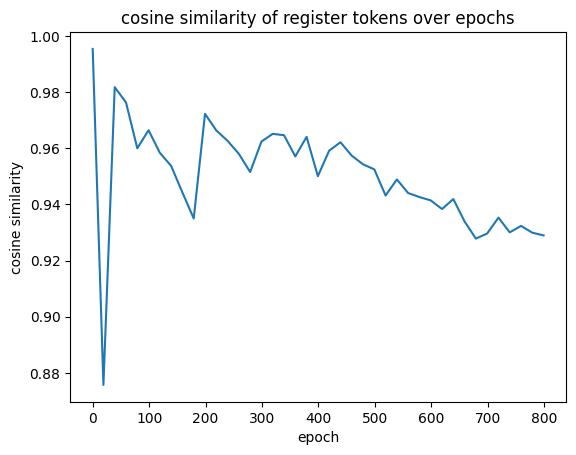

In [9]:
pths = os.listdir('../reg_checkpoints')
if "log.txt" in pths:
    pths.remove("log.txt")
if "best_checkpoint.pth" in pths:
    pths.remove("best_checkpoint.pth")
if "checkpoint.pth" in pths:
    pths.remove("checkpoint.pth")
if "deit_reg" in pths:
    pths.remove("deit_reg")

pths = sorted(pths, key=lambda x: int(x.split('checkpoint')[-1].split('.pth')[0]))
pths = [pths[i] for i in range(0, len(pths), 1)]

num_regs = 4
model = models_v2_regs.vit_models(
    img_size = 224, patch_size=16, num_regs = 4, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=models_v2_regs.Layer_scale_init_Block)
model.default_cfg = models_v2_regs._cfg()

imgs = all_images

import torch
import concurrent.futures
from tqdm import tqdm

# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper function to compute cosine similarity for one image
def compute_cosine_similarity_for_image(img, model, block, device):
    x = to_tensor(img).to(device)  # Move the image tensor to the GPU
    img_resized = x.permute(1, 2, 0) * 0.5 + 0.5

    y = model(x.unsqueeze(0))  # Perform inference on the GPU
    reg_weights = block.attn.reg_attn_maps[0].mean(dim=0)

    regs = []
    for l, reg_token in enumerate(reg_weights):
        regs.append(reg_weights[l, 4:].detach().view(14, 14))

    # calculate average cosine similarity between all pairs of reg tokens
    cos_sim = 0
    for i in range(len(regs)):
        for j in range(i + 1, len(regs)):
            cos_sim += F.cosine_similarity(regs[i].view(-1), regs[j].view(-1), dim=0)

    cos_sim /= len(regs) * (len(regs) - 1) / 2
    return cos_sim.item()

# Initialize cos_sim_list to store results
cos_sims = {}

# Move the model to the GPU
for file in pths:
    epoch = int(file.split('checkpoint')[-1].split('.pth')[0])
    print('epoch ', epoch)
    checkpoint = torch.load(f'../reg_checkpoints/{file}', map_location=device)  # Load checkpoint to GPU

    model.load_state_dict(checkpoint["model"])
    model.to(device)  # Ensure the model is on the GPU
    block = model.blocks[-1]
    block.attn.forward = my_forward_wrapper(block.attn)

    cos_sim_list = []

    # Use ThreadPoolExecutor to parallelize the for loop
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Use tqdm to show progress bar
        results = list(tqdm(executor.map(lambda img: compute_cosine_similarity_for_image(img, model, block, device), imgs),
                            total=len(imgs), desc="Processing Images", unit="img"))

        # Collect results from parallel execution
        cos_sim_list = results

    # Average cos_sim_list
    cos_sims[epoch] = np.mean(cos_sim_list)
    print('cosine similarity', cos_sims[epoch])

# Plot cosine similarity of register tokens over epochs
plt.plot(cos_sims.keys(), cos_sims.values())
plt.xlabel('epoch')
plt.ylabel('cosine similarity')
plt.title('cosine similarity of register tokens over epochs')
plt.show()


